### 0.Imports

In [71]:
%load_ext autoreload
%autoreload 2

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np
import polars as pl

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Vigilar progreso bucles
# -----------------------------------------------------------------------
from tqdm import tqdm

# Gestionar los warnings
# -----------------------------------------------------------------------
import warnings

# modificar el path
# -----------------------------------------------------------------------
import sys
sys.path.append("..")

# importar funciones de soporte
# -----------------------------------------------------------------------
import src.soporte_eda as se
import src.soporte_preprocesamiento as sp
import src.soporte_outliers as so
import src.ab_testing_support as ats

# evaluar objetos literales
# -----------------------------------------------------------------------
from ast import literal_eval 

# statistics functions
# -----------------------------------------------------------------------
from scipy.stats import pearsonr, spearmanr, pointbiserialr


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 0.1 Functions under construction

# 1. Introduction - Madrid rental prices - Preprocessing

## 1.1 Data import

In [72]:
pd.set_option("display.max_columns",40)
rent_df = pd.read_csv("../datos/explored/rent_df_explored_v1.csv", index_col=0)
rent_df.head()

,numPhotos,price,propertyType,size,exterior,rooms,bathrooms,distance,priceByArea,hasPlan,has360,hasVideo,hasLift,parkingSpace_included_in_listing,floor_grouped,municipality_grouped
1,12,750.0,flat,60.0,True,1,1,7037,12.500000,False,False,False,True,False,3.0,Madrid
2,21,750.0,flat,70.0,True,2,1,16145,10.714286,True,False,True,False,False,0.0,Other
3,28,400.0,penthouse,67.0,True,2,2,55041,5.970149,False,True,False,False,False,2.0,Other
6,11,590.0,flat,70.0,True,3,2,56596,8.428571,False,False,False,False,False,NaN,Other
7,17,684.0,studio,45.0,True,0,1,10656,15.200000,True,True,True,False,False,NaN,Madrid


In [73]:
rent_df["bathrooms"] = rent_df["bathrooms"].astype("O")
rent_df["floor_grouped"].fillna("unknown",inplace=True)

C:\Users\Miguel\AppData\Local\Temp\ipykernel_32240\4113922623.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rent_df["floor_grouped"].fillna("unknown",inplace=True)


# 2. Preprocessing

## 2.1 Missing

As previously, not necessary to impute as no retained columns have missing values.

## 2.2 Outliers

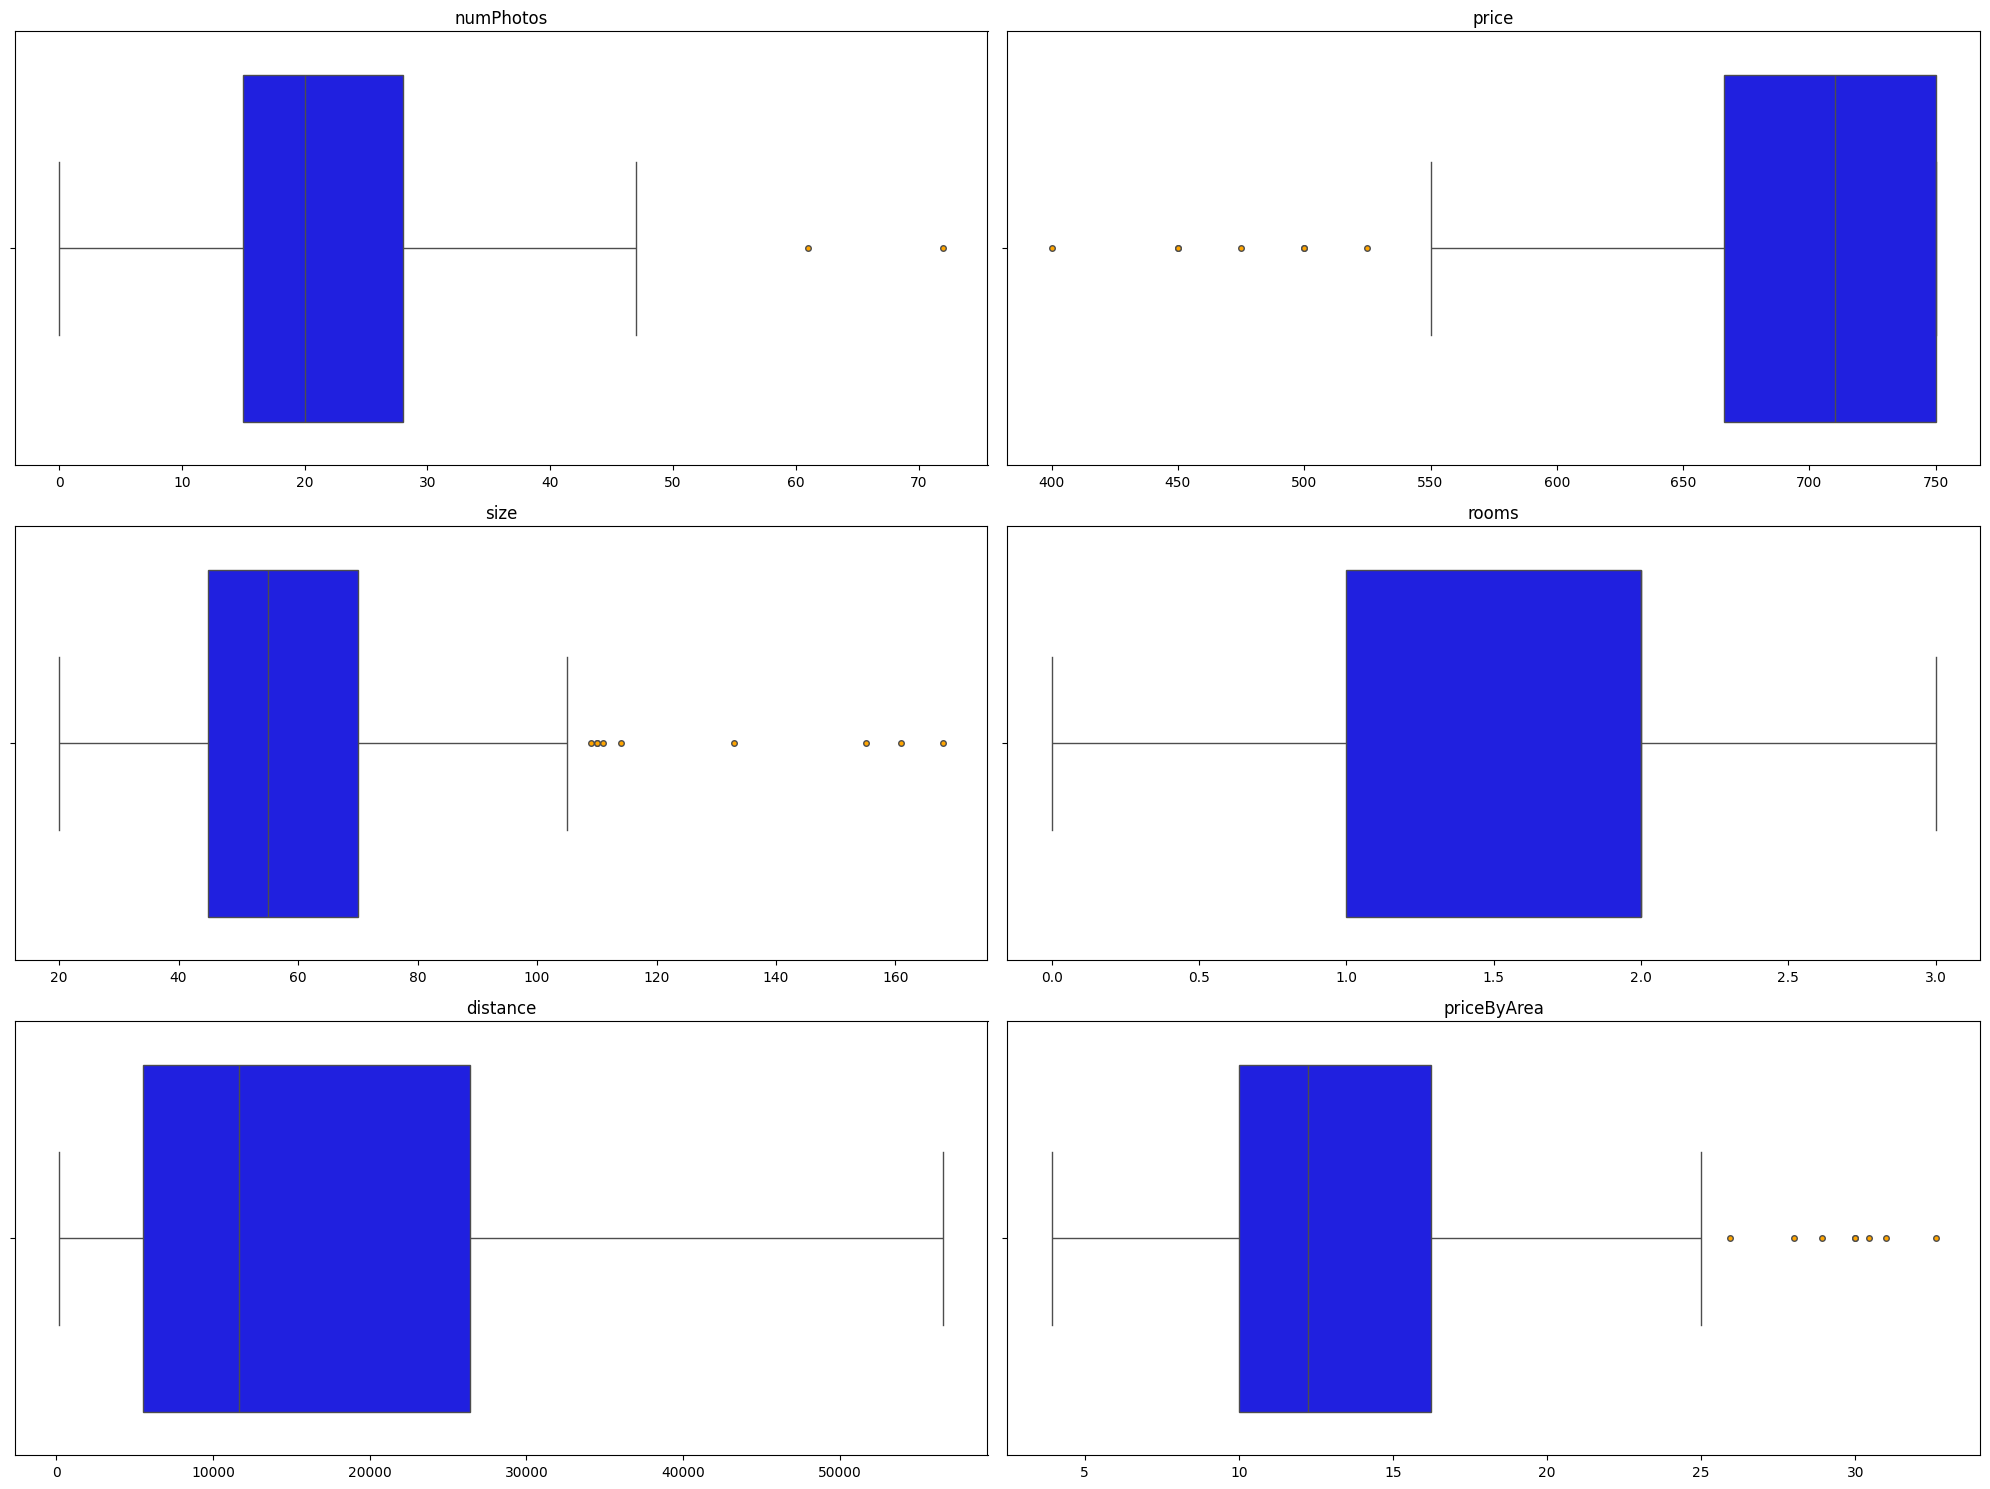

In [74]:
gestor_outliers = so.GestionOutliersUnivariados(rent_df)

gestor_outliers.visualizar_outliers_univariados()

Let's check the outliers in priceByArea beyond 25 euros per squared metre:

In [75]:
rent_df[rent_df["priceByArea"] > 25]

,numPhotos,price,propertyType,size,exterior,rooms,bathrooms,distance,priceByArea,hasPlan,has360,hasVideo,hasLift,parkingSpace_included_in_listing,floor_grouped,municipality_grouped
34,13,750.0,studio,25.0,False,0,1,533,30.000000,False,False,False,True,False,4 or more,Madrid
82,25,700.0,flat,27.0,False,1,1,1391,25.925926,False,False,False,False,False,3.0,Madrid
169,20,700.0,studio,23.0,True,0,1,1271,30.434783,True,True,True,False,False,unknown,Madrid
215,28,723.0,studio,25.0,True,0,1,16775,28.920000,True,False,True,True,True,unknown,Other
236,24,750.0,studio,25.0,True,0,1,3177,30.000000,True,False,False,True,False,4 or more,Madrid
284,21,750.0,studio,23.0,True,0,1,1367,32.608696,False,False,True,True,False,4 or more,Madrid
342,17,620.0,studio,20.0,False,0,1,1893,31.000000,False,False,False,True,False,1.0,Madrid
402,18,700.0,studio,25.0,False,0,1,691,28.000000,False,False,False,False,False,0.0,Madrid


For the price by area model, it can be a good idea to remove this univariate outliers and cap the model to 25 squared meters.

In [76]:
rent_df[rent_df["price"] < 550]

,numPhotos,price,propertyType,size,exterior,rooms,bathrooms,distance,priceByArea,hasPlan,has360,hasVideo,hasLift,parkingSpace_included_in_listing,floor_grouped,municipality_grouped
3,28,400.0,penthouse,67.0,True,2,2,55041,5.970149,False,True,False,False,False,2.0,Other
60,13,500.0,studio,28.0,False,0,1,769,17.857143,False,False,False,False,False,1.0,Madrid
116,6,500.0,flat,45.0,True,1,1,32188,11.111111,False,False,False,False,False,unknown,Other
224,6,450.0,penthouse,60.0,True,1,1,53238,7.500000,False,False,False,False,False,unknown,Other
289,27,475.0,flat,79.0,True,2,2,45077,6.012658,False,False,False,True,False,2.0,Other
319,25,525.0,flat,40.0,True,1,1,43059,13.125000,True,True,True,True,False,3.0,Other
436,10,450.0,flat,40.0,True,1,1,46273,11.250000,False,False,True,False,False,1.0,Other


In [77]:
rent_df[rent_df["size"] > 105]

,numPhotos,price,propertyType,size,exterior,rooms,bathrooms,distance,priceByArea,hasPlan,has360,hasVideo,hasLift,parkingSpace_included_in_listing,floor_grouped,municipality_grouped
70,39,720.0,flat,133.0,False,3,2,19453,5.413534,True,True,False,True,True,1.0,Other
207,12,750.0,flat,111.0,True,2,2,20583,6.756757,False,False,False,True,False,4 or more,Other
230,72,660.0,flat,155.0,False,3,2,41119,4.258065,True,True,True,False,False,unknown,Other
234,29,660.0,flat,168.0,False,3,2,41221,3.928571,True,True,True,True,True,3.0,Other
272,28,730.0,flat,161.0,True,3,1,44159,4.534161,True,True,True,False,False,3.0,Other
274,25,720.0,flat,110.0,False,2,1,21417,6.545455,True,True,True,True,True,unknown,Other
299,23,750.0,flat,109.0,True,2,2,24455,6.880734,False,False,False,True,True,3.0,Other
405,35,750.0,duplex,114.0,True,3,2,28099,6.578947,False,False,False,False,False,1.0,Other
417,19,750.0,flat,110.0,True,3,2,27976,6.818182,False,False,False,False,False,1.0,Other


## 2.2 Encodings

The purpose now is to look for differences in categories that can serve the purpose of adding information to the target variable taking either price or priceByArea as targets, to see which brings better differentiations:
- Price
- PriceByArea

Let's start by applying a general AB testing to categorical features, by price as target feature:

Realizando AB-Testing de la variable 'propertyType'
Las muestras de los siguientes grupos son pequeñas:


propertyType
duplex       13
penthouse    10
studio       48
Name: price, dtype: int64

APLICANDO TESTS DE NORMALIDAD.

Definición de las hipótesis:
H0: La variable medida sigue una distribución normal en el grupo evaluado.
H1: La variable medida NO sigue una distribución normal en el grupo evaluado.

Los supuestos paramétricos no se cumplen. Procediendo con tests NO paramétricos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE KRUSKAL-WALLIS TEST:

Definición de las hipótesis:
H0: Los grupos presentan medianas equivalentes u homogéneas.
H1: Los grupos NO presentan medianas equivalentes u homogéneas.

Con un p-valor igual a 0.366 > alpha 0.05, en la variable propertyType no existen diferencias entre la medianas de los grupos.
----------------------------------------------------------------------------------




Realizando AB-Testing de la variable 'exterior'
Las muestras de los siguientes grupos son pequeñas:


exterior
False    62
Name: price, dtype: int64

APLICANDO TESTS DE NORMALIDAD.

Definición de las hipótesis:
H0: La variable medida sigue una distribución normal en el grupo evaluado.
H1: La variable medida NO sigue una distribución normal en el grupo evaluado.

Los supuestos paramétricos no se cumplen. Procediendo con tests NO paramétricos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE MANN-WHITNEY U:

Definición de las hipótesis:
H0: Los grupos presentan medianas equivalentes u homogéneas.
H1: Los grupos NO presentan medianas equivalentes u homogéneas.

Con un p-valor igual a 0.448 > alpha 0.05, en la variable exterior no existen diferencias entre la medianas de los grupos.
----------------------------------------------------------------------------------




Realizando AB-Testing de la variable 'bathrooms'
Las muestras de los siguientes grupos son pequeñas:


bathrooms
2    28
Name: price, dtype: int64

APLICANDO TESTS DE NORMALIDAD.

Definición de las hipótesis:
H0: La variable medida sigue una distribución normal en el grupo evaluado.
H1: La variable medida NO sigue una distribución normal en el grupo evaluado.

Los supuestos paramétricos no se cumplen. Procediendo con tests NO paramétricos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE MANN-WHITNEY U:

Definición de las hipótesis:
H0: Los grupos presentan medianas equivalentes u homogéneas.
H1: Los grupos NO presentan medianas equivalentes u homogéneas.

Con un p-valor igual a 0.467 > alpha 0.05, en la variable bathrooms no existen diferencias entre la medianas de los grupos.
----------------------------------------------------------------------------------




Realizando AB-Testing de la variable 'hasPlan'
APLICANDO TESTS DE NORMALIDAD.

Definición de las hipótesis:
H0: La variable medida sigue una distribución normal en el grupo evaluado.
H1: La variable medida NO sigue u

has360
True    96
Name: price, dtype: int64

APLICANDO TESTS DE NORMALIDAD.

Definición de las hipótesis:
H0: La variable medida sigue una distribución normal en el grupo evaluado.
H1: La variable medida NO sigue una distribución normal en el grupo evaluado.

Los supuestos paramétricos no se cumplen. Procediendo con tests NO paramétricos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE MANN-WHITNEY U:

Definición de las hipótesis:
H0: Los grupos presentan medianas equivalentes u homogéneas.
H1: Los grupos NO presentan medianas equivalentes u homogéneas.

Con un p-valor igual a 0.954 > alpha 0.05, en la variable has360 no existen diferencias entre la medianas de los grupos.
----------------------------------------------------------------------------------




Realizando AB-Testing de la variable 'hasVideo'
APLICANDO TESTS DE NORMALIDAD.

Definición de las hipótesis:
H0: La variable medida sigue una distribución normal en el grupo evaluado.
H1: La variable medida NO sigue una

,group1,group2,meddiff,p-adj,reject_H0
0,False,True,20.0,0.025,True


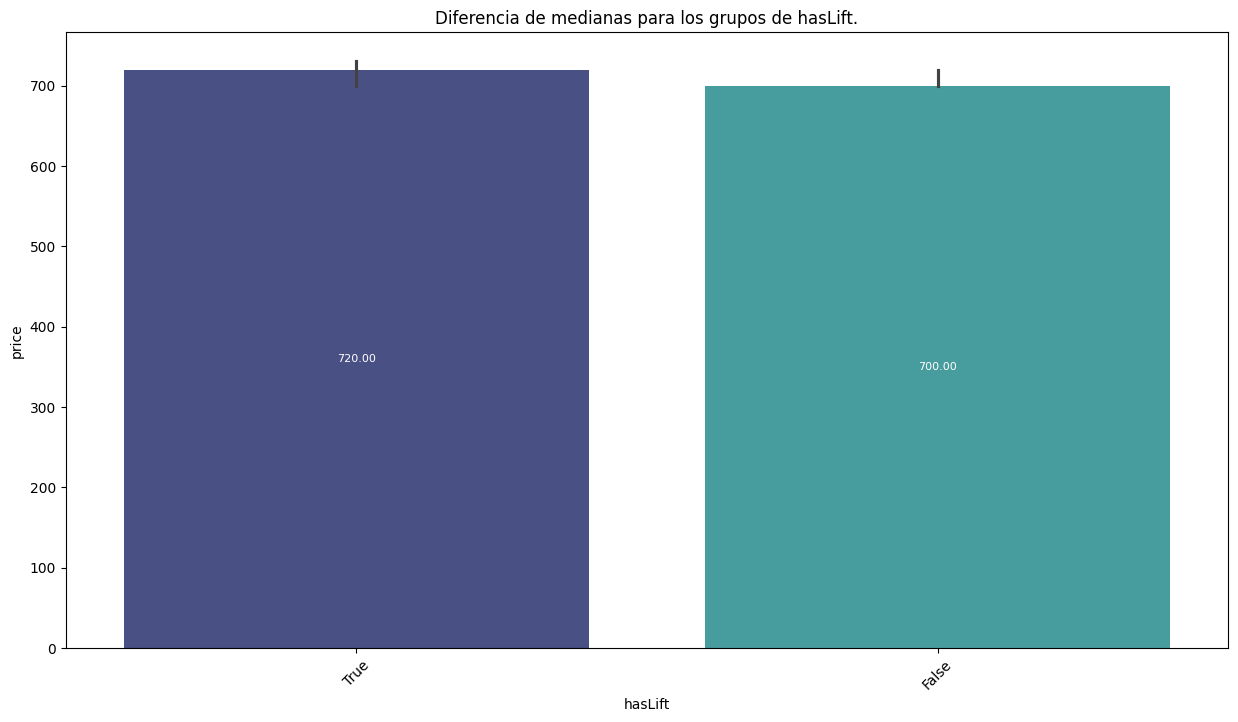




Realizando AB-Testing de la variable 'parkingSpace_included_in_listing'
Las muestras de los siguientes grupos son pequeñas:


parkingSpace_included_in_listing
True    70
Name: price, dtype: int64

APLICANDO TESTS DE NORMALIDAD.

Definición de las hipótesis:
H0: La variable medida sigue una distribución normal en el grupo evaluado.
H1: La variable medida NO sigue una distribución normal en el grupo evaluado.

Los supuestos paramétricos no se cumplen. Procediendo con tests NO paramétricos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE MANN-WHITNEY U:

Definición de las hipótesis:
H0: Los grupos presentan medianas equivalentes u homogéneas.
H1: Los grupos NO presentan medianas equivalentes u homogéneas.

Con un p-valor igual a 0.864 > alpha 0.05, en la variable parkingSpace_included_in_listing no existen diferencias entre la medianas de los grupos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE DUNN, POST-HOC NO PARAMÉTRICO

Test de Dunn (comparaciones por pares):
Hipótesis Nula (H0): Las medianas de los grupos comparados son iguales.
Hipótesis Alternativa (H1): Las 

,group1,group2,meddiff,p-adj,reject_H0


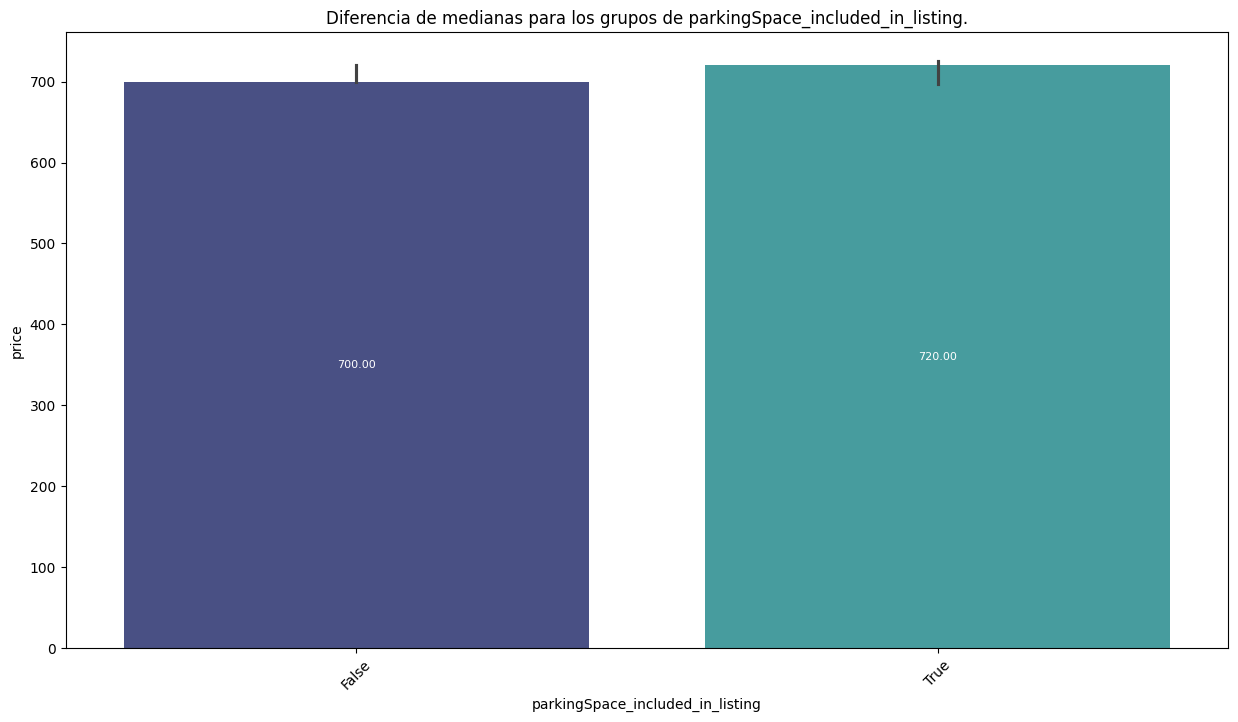




Realizando AB-Testing de la variable 'floor_grouped'
Las muestras de los siguientes grupos son pequeñas:


floor_grouped
0.0          60
0.5           6
1.0          68
2.0          56
3.0          47
4 or more    49
unknown      51
Name: price, dtype: int64

APLICANDO TESTS DE NORMALIDAD.

Definición de las hipótesis:
H0: La variable medida sigue una distribución normal en el grupo evaluado.
H1: La variable medida NO sigue una distribución normal en el grupo evaluado.

Los supuestos paramétricos no se cumplen. Procediendo con tests NO paramétricos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE KRUSKAL-WALLIS TEST:

Definición de las hipótesis:
H0: Los grupos presentan medianas equivalentes u homogéneas.
H1: Los grupos NO presentan medianas equivalentes u homogéneas.

Con un p-valor igual a 0.001 > alpha 0.05, en la variable floor_grouped, las medianas muestran distribuciones diferentes.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE DUNN, POST-HOC NO PARAMÉTRICO

Test de Dunn (comparaciones por pares):
Hipótesis Nula (H0): Las medianas de los grupos comparados son iguales.
Hipótesis Alternativa (H1): Las medianas de los grup

,group1,group2,meddiff,p-adj,reject_H0
4,0.0,4 or more,30.0,0.002,True
20,4 or more,unknown,-35.0,0.004,True


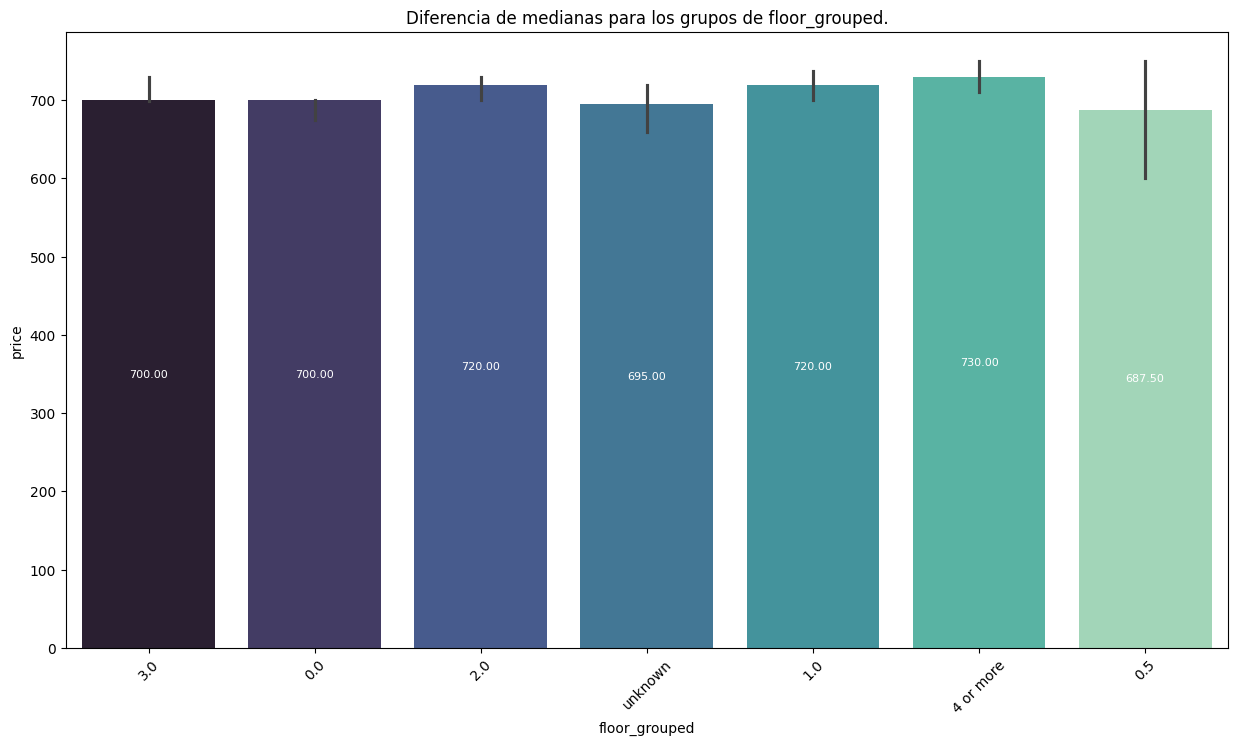




Realizando AB-Testing de la variable 'municipality_grouped'
APLICANDO TESTS DE NORMALIDAD.

Definición de las hipótesis:
H0: La variable medida sigue una distribución normal en el grupo evaluado.
H1: La variable medida NO sigue una distribución normal en el grupo evaluado.

Los supuestos paramétricos no se cumplen. Procediendo con tests NO paramétricos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE MANN-WHITNEY U:

Definición de las hipótesis:
H0: Los grupos presentan medianas equivalentes u homogéneas.
H1: Los grupos NO presentan medianas equivalentes u homogéneas.

Con un p-valor igual a 0.002 > alpha 0.05, en la variable municipality_grouped, las medianas muestran distribuciones diferentes.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE DUNN, POST-HOC NO PARAMÉTRICO

Test de Dunn (comparaciones por pares):
Hipótesis Nula (H0): Las medianas de los grupos comparados 

,group1,group2,meddiff,p-adj,reject_H0
0,Madrid,Other,-20.0,0.002,True


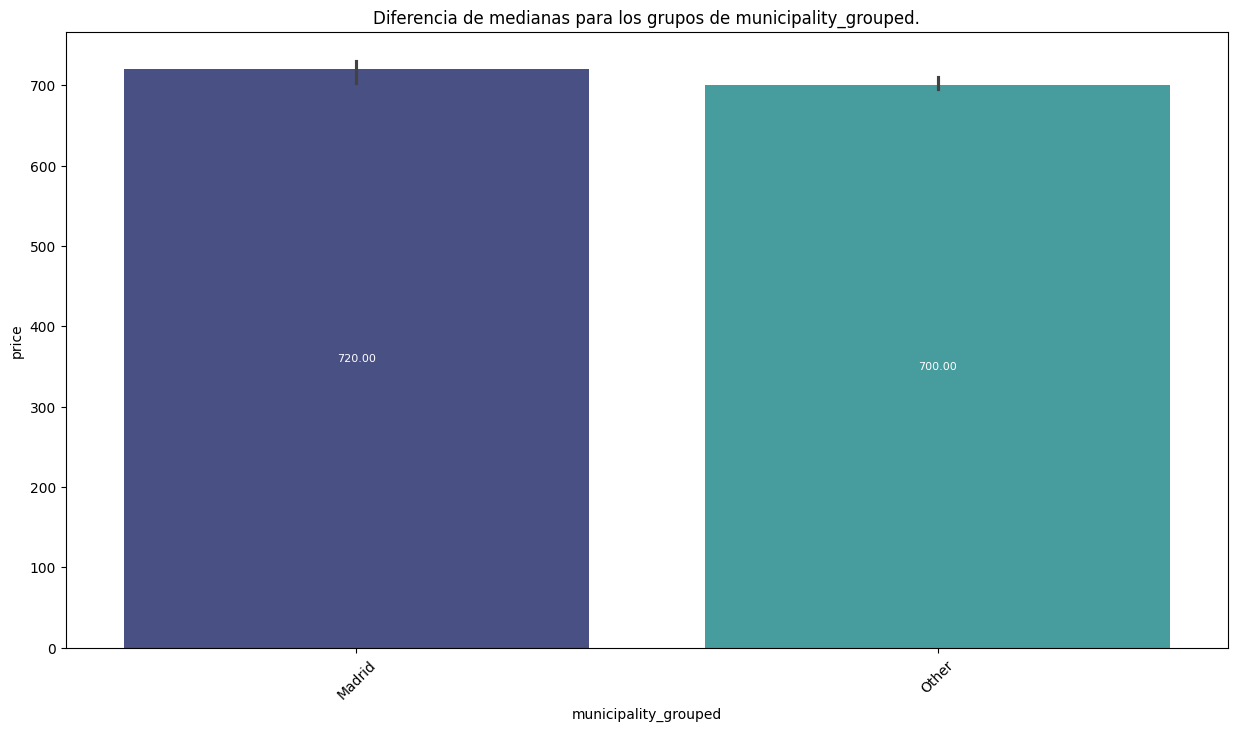

In [78]:
# ignorar warnings momentaneamente para evitar warnigns del soporte
warnings.filterwarnings("ignore")

tester = ats.AB_testing(rent_df, "price", 0.05, verbose=False)

for columna_categorica in rent_df.select_dtypes(include=["O","category",bool]):
    print(f"Realizando AB-Testing de la variable '{columna_categorica}'")
    print("===============================================")
    tester.evaluar_ab_testing(columna_categorica)
    print("\n\n")


# resturar warnings
warnings.filterwarnings("default")

Now, let's repeat the same exercise with priceByArea:

Realizando AB-Testing de la variable 'propertyType'
Las muestras de los siguientes grupos son pequeñas:


propertyType
duplex       13
penthouse    10
studio       48
Name: priceByArea, dtype: int64

APLICANDO TESTS DE NORMALIDAD.

Definición de las hipótesis:
H0: La variable medida sigue una distribución normal en el grupo evaluado.
H1: La variable medida NO sigue una distribución normal en el grupo evaluado.

Los supuestos paramétricos no se cumplen. Procediendo con tests NO paramétricos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE KRUSKAL-WALLIS TEST:

Definición de las hipótesis:
H0: Los grupos presentan medianas equivalentes u homogéneas.
H1: Los grupos NO presentan medianas equivalentes u homogéneas.

Con un p-valor igual a 0.0 > alpha 0.05, en la variable propertyType, las medianas muestran distribuciones diferentes.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE DUNN, POST-HOC NO PARAMÉTRICO

Test de Dunn (comparaciones por pares):
Hipótesis Nula (H0): Las medianas de los grupos comparados son iguales.
Hipótesis Alternativa (H1): Las medianas de los grupos 

,group1,group2,meddiff,p-adj,reject_H0
2,duplex,studio,9.578,0.0,True
4,flat,studio,7.534,0.0,True
5,penthouse,studio,9.904,0.0,True


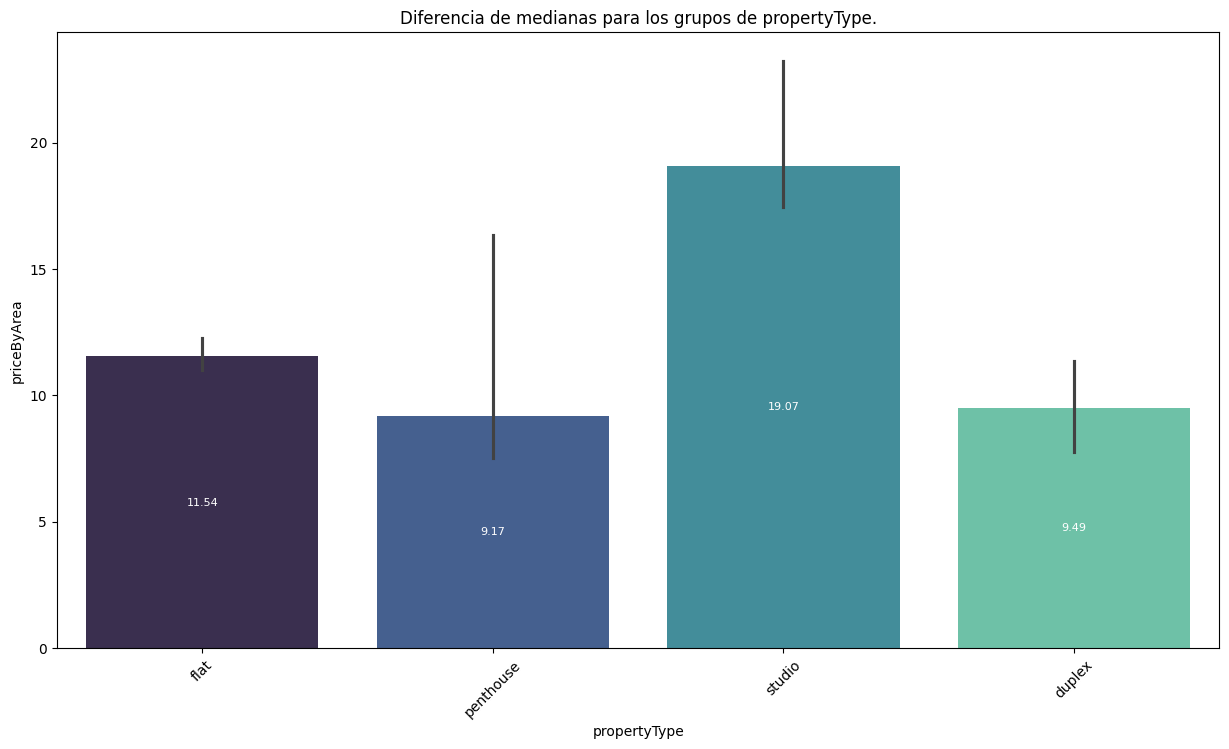




Realizando AB-Testing de la variable 'exterior'
Las muestras de los siguientes grupos son pequeñas:


exterior
False    62
Name: priceByArea, dtype: int64

APLICANDO TESTS DE NORMALIDAD.

Definición de las hipótesis:
H0: La variable medida sigue una distribución normal en el grupo evaluado.
H1: La variable medida NO sigue una distribución normal en el grupo evaluado.

Los supuestos paramétricos no se cumplen. Procediendo con tests NO paramétricos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE MANN-WHITNEY U:

Definición de las hipótesis:
H0: Los grupos presentan medianas equivalentes u homogéneas.
H1: Los grupos NO presentan medianas equivalentes u homogéneas.

Con un p-valor igual a 0.0 > alpha 0.05, en la variable exterior, las medianas muestran distribuciones diferentes.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE DUNN, POST-HOC NO PARAMÉTRICO

Test de Dunn (comparaciones por pares):
Hipótesis Nula (H0): Las medianas de los grupos comparados son iguales.
Hipótesis Alternativa (H1): Las medianas de los grupos comparado

,group1,group2,meddiff,p-adj,reject_H0
0,False,True,-5.072,0.0,True


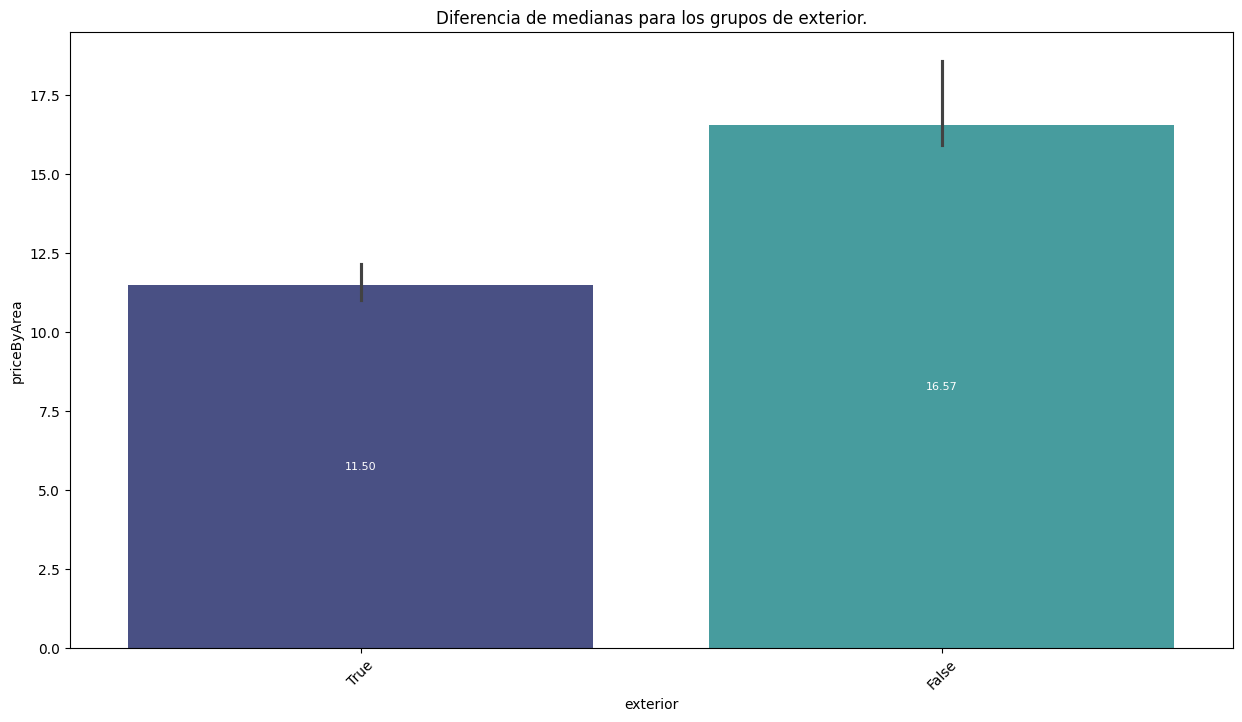




Realizando AB-Testing de la variable 'bathrooms'
Las muestras de los siguientes grupos son pequeñas:


bathrooms
2    28
Name: priceByArea, dtype: int64

APLICANDO TESTS DE NORMALIDAD.

Definición de las hipótesis:
H0: La variable medida sigue una distribución normal en el grupo evaluado.
H1: La variable medida NO sigue una distribución normal en el grupo evaluado.

Los supuestos paramétricos no se cumplen. Procediendo con tests NO paramétricos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE MANN-WHITNEY U:

Definición de las hipótesis:
H0: Los grupos presentan medianas equivalentes u homogéneas.
H1: Los grupos NO presentan medianas equivalentes u homogéneas.

Con un p-valor igual a 0.0 > alpha 0.05, en la variable bathrooms, las medianas muestran distribuciones diferentes.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE DUNN, POST-HOC NO PARAMÉTRICO

Test de Dunn (comparaciones por pares):
Hipótesis Nula (H0): Las medianas de los grupos comparados son iguales.
Hipótesis Alternativa (H1): Las medianas de los grupos comparad

,group1,group2,meddiff,p-adj,reject_H0
0,1,2,-5.009,0.0,True


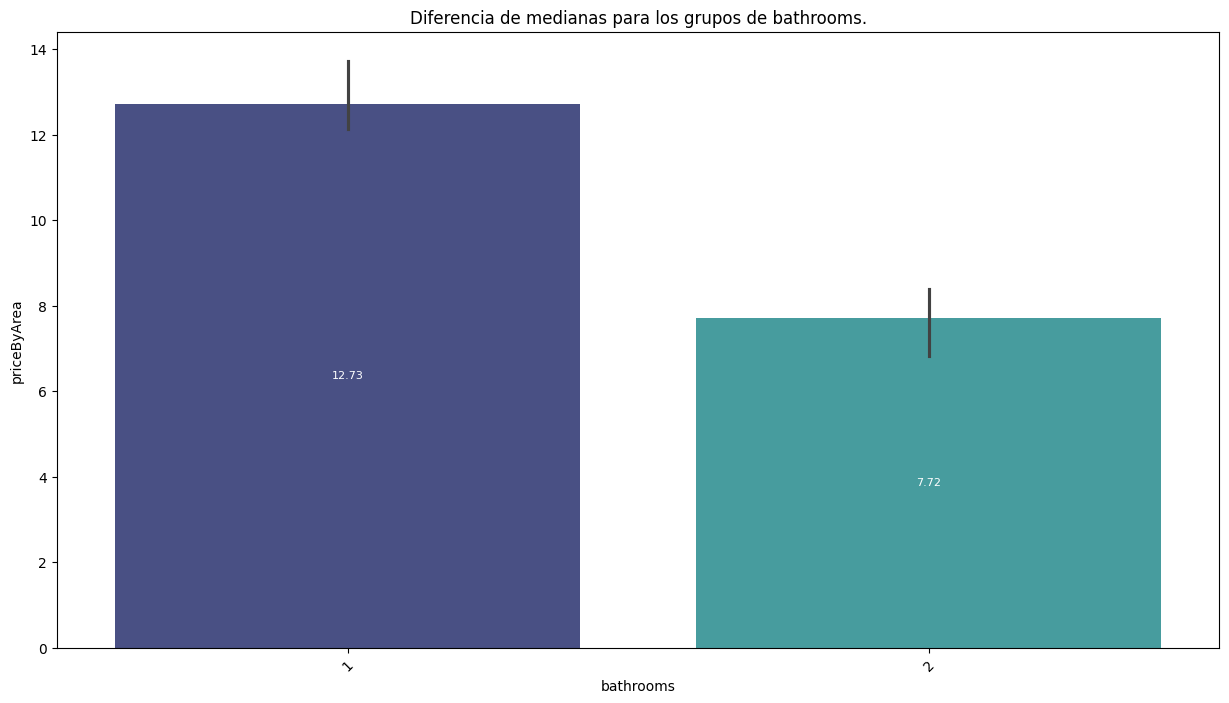




Realizando AB-Testing de la variable 'hasPlan'
APLICANDO TESTS DE NORMALIDAD.

Definición de las hipótesis:
H0: La variable medida sigue una distribución normal en el grupo evaluado.
H1: La variable medida NO sigue una distribución normal en el grupo evaluado.

Los supuestos paramétricos no se cumplen. Procediendo con tests NO paramétricos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE MANN-WHITNEY U:

Definición de las hipótesis:
H0: Los grupos presentan medianas equivalentes u homogéneas.
H1: Los grupos NO presentan medianas equivalentes u homogéneas.

Con un p-valor igual a 0.029 > alpha 0.05, en la variable hasPlan, las medianas muestran distribuciones diferentes.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE DUNN, POST-HOC NO PARAMÉTRICO

Test de Dunn (comparaciones por pares):
Hipótesis Nula (H0): Las medianas de los grupos comparados son iguales.
Hipótesis Alt

,group1,group2,meddiff,p-adj,reject_H0
0,False,True,2.3,0.029,True


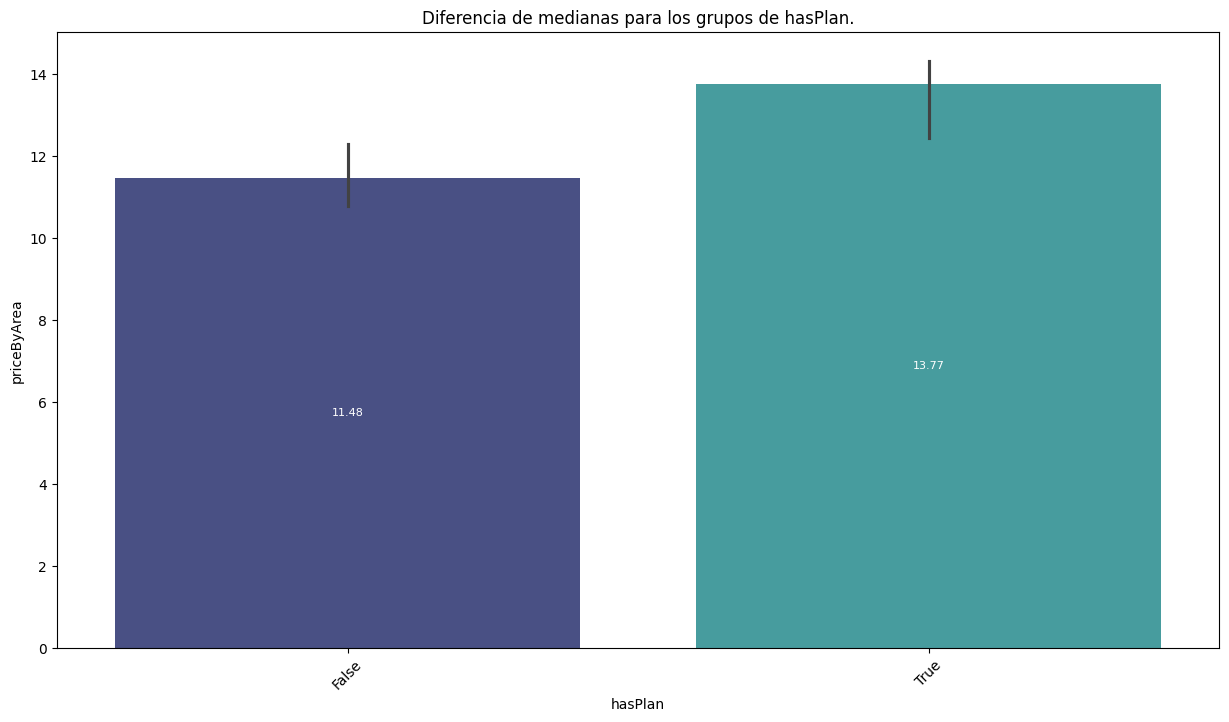




Realizando AB-Testing de la variable 'has360'
Las muestras de los siguientes grupos son pequeñas:


has360
True    96
Name: priceByArea, dtype: int64

APLICANDO TESTS DE NORMALIDAD.

Definición de las hipótesis:
H0: La variable medida sigue una distribución normal en el grupo evaluado.
H1: La variable medida NO sigue una distribución normal en el grupo evaluado.

Los supuestos paramétricos no se cumplen. Procediendo con tests NO paramétricos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE MANN-WHITNEY U:

Definición de las hipótesis:
H0: Los grupos presentan medianas equivalentes u homogéneas.
H1: Los grupos NO presentan medianas equivalentes u homogéneas.

Con un p-valor igual a 0.248 > alpha 0.05, en la variable has360 no existen diferencias entre la medianas de los grupos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE DUNN, POST-HOC NO PARAMÉTRICO

Test de Dunn (comparaciones por pares):
Hipótesis Nula (H0): Las medianas de los grupos comparados son iguales.
Hipótesis Alternativa (H1): Las medianas de los grupos com

,group1,group2,meddiff,p-adj,reject_H0


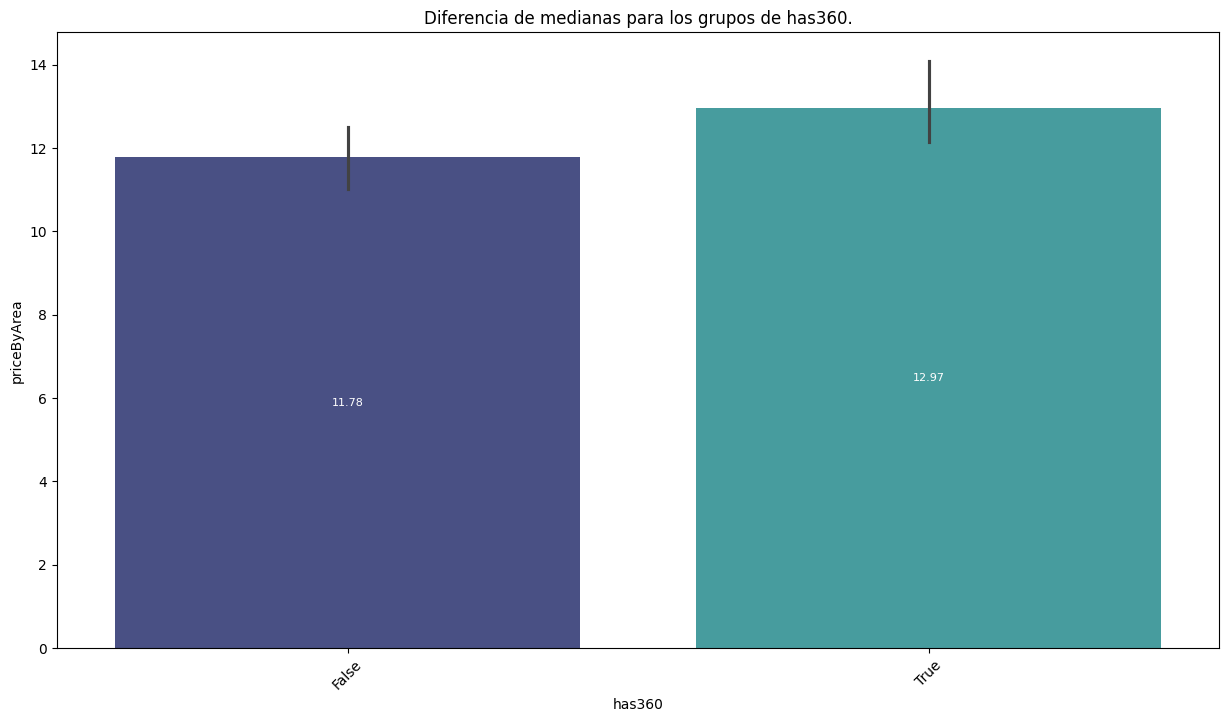




Realizando AB-Testing de la variable 'hasVideo'
APLICANDO TESTS DE NORMALIDAD.

Definición de las hipótesis:
H0: La variable medida sigue una distribución normal en el grupo evaluado.
H1: La variable medida NO sigue una distribución normal en el grupo evaluado.

Los supuestos paramétricos no se cumplen. Procediendo con tests NO paramétricos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE MANN-WHITNEY U:

Definición de las hipótesis:
H0: Los grupos presentan medianas equivalentes u homogéneas.
H1: Los grupos NO presentan medianas equivalentes u homogéneas.

Con un p-valor igual a 0.045 > alpha 0.05, en la variable hasVideo, las medianas muestran distribuciones diferentes.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE DUNN, POST-HOC NO PARAMÉTRICO

Test de Dunn (comparaciones por pares):
Hipótesis Nula (H0): Las medianas de los grupos comparados son iguales.
Hipótesis A

,group1,group2,meddiff,p-adj,reject_H0
0,False,True,1.554,0.045,True


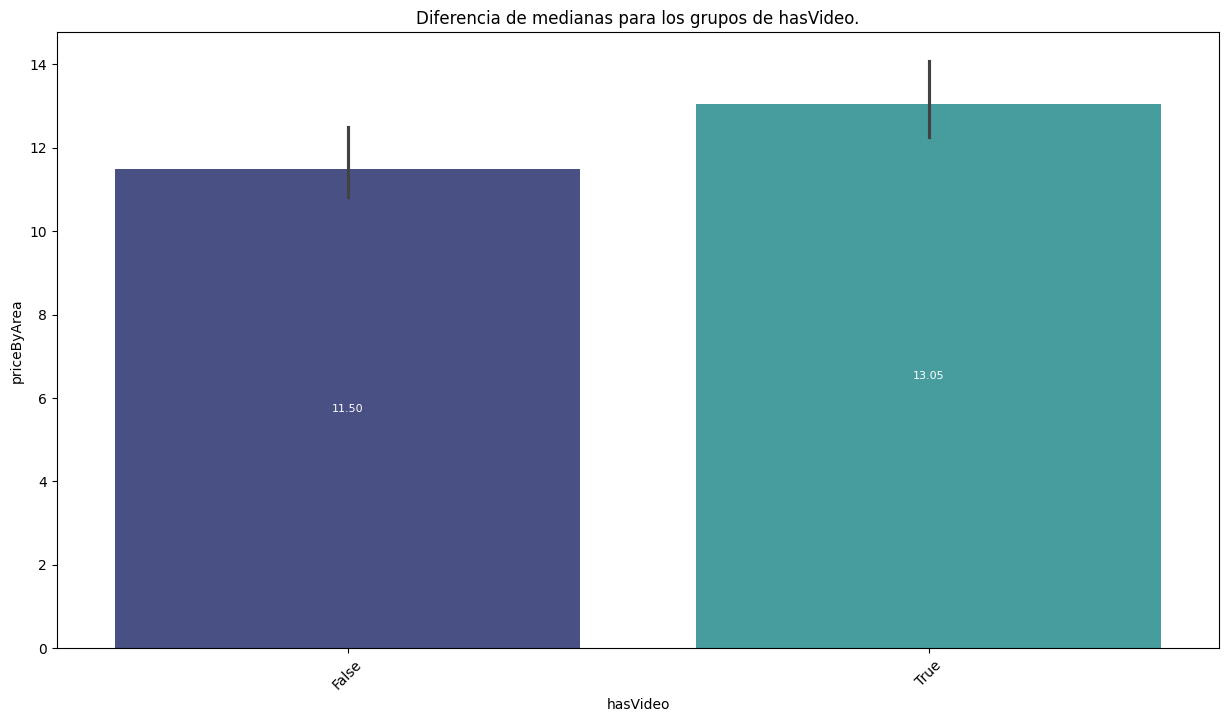




Realizando AB-Testing de la variable 'hasLift'
APLICANDO TESTS DE NORMALIDAD.

Definición de las hipótesis:
H0: La variable medida sigue una distribución normal en el grupo evaluado.
H1: La variable medida NO sigue una distribución normal en el grupo evaluado.

Los supuestos paramétricos no se cumplen. Procediendo con tests NO paramétricos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE MANN-WHITNEY U:

Definición de las hipótesis:
H0: Los grupos presentan medianas equivalentes u homogéneas.
H1: Los grupos NO presentan medianas equivalentes u homogéneas.

Con un p-valor igual a 0.594 > alpha 0.05, en la variable hasLift no existen diferencias entre la medianas de los grupos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE DUNN, POST-HOC NO PARAMÉTRICO

Test de Dunn (comparaciones por pares):
Hipótesis Nula (H0): Las medianas de los grupos comparados son iguales.
Hipótes

,group1,group2,meddiff,p-adj,reject_H0


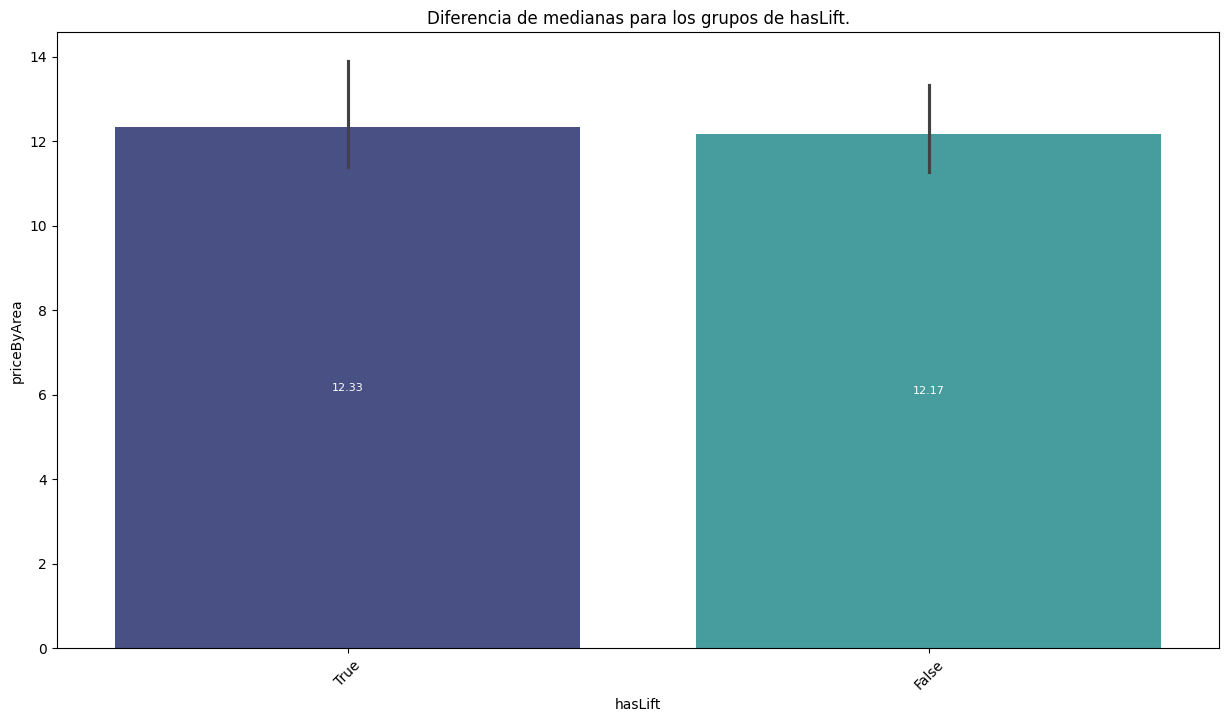




Realizando AB-Testing de la variable 'parkingSpace_included_in_listing'
Las muestras de los siguientes grupos son pequeñas:


parkingSpace_included_in_listing
True    70
Name: priceByArea, dtype: int64

APLICANDO TESTS DE NORMALIDAD.

Definición de las hipótesis:
H0: La variable medida sigue una distribución normal en el grupo evaluado.
H1: La variable medida NO sigue una distribución normal en el grupo evaluado.

Los supuestos paramétricos no se cumplen. Procediendo con tests NO paramétricos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE MANN-WHITNEY U:

Definición de las hipótesis:
H0: Los grupos presentan medianas equivalentes u homogéneas.
H1: Los grupos NO presentan medianas equivalentes u homogéneas.

Con un p-valor igual a 0.053 > alpha 0.05, en la variable parkingSpace_included_in_listing no existen diferencias entre la medianas de los grupos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE DUNN, POST-HOC NO PARAMÉTRICO

Test de Dunn (comparaciones por pares):
Hipótesis Nula (H0): Las medianas de los grupos comparados son iguales.
Hipótesis Alternativa (H1): Las 

,group1,group2,meddiff,p-adj,reject_H0


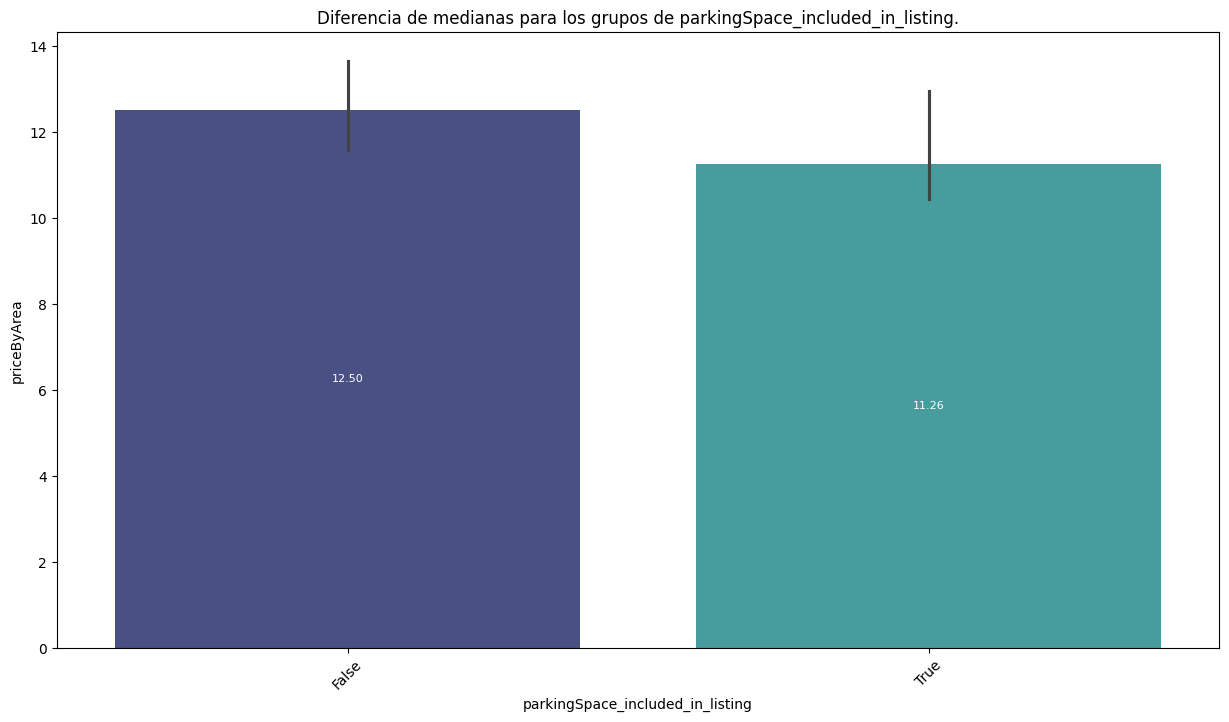




Realizando AB-Testing de la variable 'floor_grouped'
Las muestras de los siguientes grupos son pequeñas:


floor_grouped
0.0          60
0.5           6
1.0          68
2.0          56
3.0          47
4 or more    49
unknown      51
Name: priceByArea, dtype: int64

APLICANDO TESTS DE NORMALIDAD.

Definición de las hipótesis:
H0: La variable medida sigue una distribución normal en el grupo evaluado.
H1: La variable medida NO sigue una distribución normal en el grupo evaluado.

Los supuestos paramétricos no se cumplen. Procediendo con tests NO paramétricos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE KRUSKAL-WALLIS TEST:

Definición de las hipótesis:
H0: Los grupos presentan medianas equivalentes u homogéneas.
H1: Los grupos NO presentan medianas equivalentes u homogéneas.

Con un p-valor igual a 0.066 > alpha 0.05, en la variable floor_grouped no existen diferencias entre la medianas de los grupos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE DUNN, POST-HOC NO PARAMÉTRICO

Test de Dunn (comparaciones por pares):
Hipótesis Nula (H0): Las medianas de los grupos comparados son iguales.
Hipótesis Alternativa (H1): Las medianas de lo

,group1,group2,meddiff,p-adj,reject_H0
5,0.0,unknown,-3.327,0.032,True


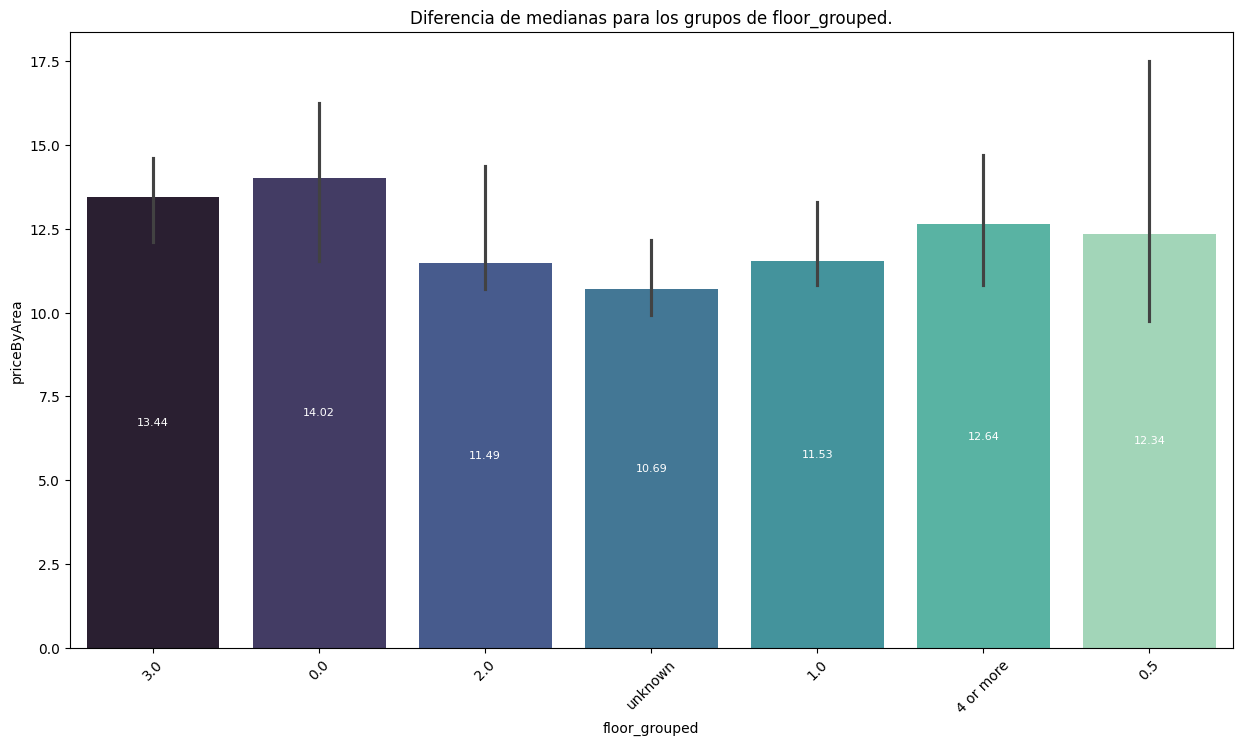




Realizando AB-Testing de la variable 'municipality_grouped'
APLICANDO TESTS DE NORMALIDAD.

Definición de las hipótesis:
H0: La variable medida sigue una distribución normal en el grupo evaluado.
H1: La variable medida NO sigue una distribución normal en el grupo evaluado.

Los supuestos paramétricos no se cumplen. Procediendo con tests NO paramétricos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE MANN-WHITNEY U:

Definición de las hipótesis:
H0: Los grupos presentan medianas equivalentes u homogéneas.
H1: Los grupos NO presentan medianas equivalentes u homogéneas.

Con un p-valor igual a 0.0 > alpha 0.05, en la variable municipality_grouped, las medianas muestran distribuciones diferentes.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE DUNN, POST-HOC NO PARAMÉTRICO

Test de Dunn (comparaciones por pares):
Hipótesis Nula (H0): Las medianas de los grupos comparados so

,group1,group2,meddiff,p-adj,reject_H0
0,Madrid,Other,-5.976,0.0,True


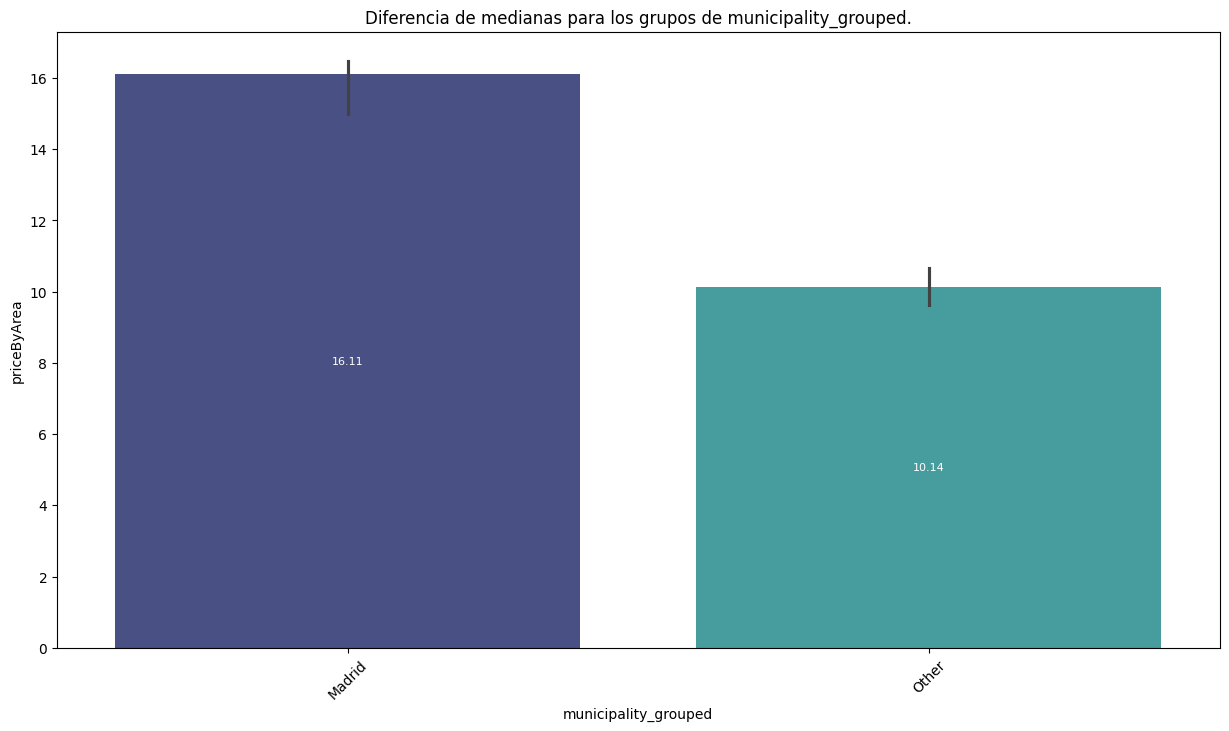

In [79]:
# ignorar warnings momentaneamente para evitar warnigns del soporte
warnings.filterwarnings("ignore")

tester = ats.AB_testing(rent_df, "priceByArea", 0.05, verbose=False)

for columna_categorica in rent_df.select_dtypes(include=["O","category",bool]):
    print(f"Realizando AB-Testing de la variable '{columna_categorica}'")
    print("===============================================")
    tester.evaluar_ab_testing(columna_categorica)
    print("\n\n")


# resturar warnings
warnings.filterwarnings("default")

- propertyType: Categories from propertyType are significantly different to studio, but not among themselves. Therefore, they can be grouped and as 2 categories would remain, one-hot encoder would be the encoder solution.

In [80]:
rent_df["p_area_property_grouped"] = np.where(rent_df["propertyType"] == "studio", "studio", "flat or other")



- Exterior has 2 categories, which are found significant. Thus, one-hot encoder is their go-to encoding.
- Bathrooms is the same case.
- Rooms: All categories are found significant and they seem to follow an order pattern. This column could then follow an ordinal encoding, one-hot encoding to properly capture its true underlying relationship with the target, at the expense of dimensionality or directly target encoding, which is the best compromise right now.
- hasPlan: Is found significant, so it will be one hot encoded as it is a binary feature.
- hasLift: Not found significant, no need to include it in the model.
- parkingSpace_included: Not found significant by the AB testing, but point biserial test found it significant in the exploration. Therefore it can be one-hot encoded and tried in the model.
- Floors: Only floor 0 is found significantly different to 'unknown'. This could be due to some small samples, so it makes sense to group some of these categories and repeat the tests.


In [81]:
rent_df["floor_grouped"].replace("0.5","1",inplace=True)

# ignorar warnings momentaneamente para evitar warnigns del soporte
warnings.filterwarnings("ignore")

tester = ats.AB_testing(rent_df, "priceByArea", 0.05, verbose=False)

tester.evaluar_ab_testing("floor_grouped")

# resturar warnings
warnings.filterwarnings("default")

Las muestras de los siguientes grupos son pequeñas:


C:\Users\Miguel\AppData\Local\Temp\ipykernel_32240\2337271927.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rent_df["floor_grouped"].replace("0.5","1",inplace=True)


floor_grouped
0.0          60
1             6
1.0          68
2.0          56
3.0          47
4 or more    49
unknown      51
Name: priceByArea, dtype: int64

APLICANDO TESTS DE NORMALIDAD.

Definición de las hipótesis:
H0: La variable medida sigue una distribución normal en el grupo evaluado.
H1: La variable medida NO sigue una distribución normal en el grupo evaluado.

Los supuestos paramétricos no se cumplen. Procediendo con tests NO paramétricos.
----------------------------------------------------------------------------------

APLICANDO EL TEST DE KRUSKAL-WALLIS TEST:

Definición de las hipótesis:
H0: Los grupos presentan medianas equivalentes u homogéneas.
H1: Los grupos NO presentan medianas equivalentes u homogéneas.

Con un p-valor igual a 0.066 > alpha 0.05, en la variable floor_grouped no existen diferencias entre la medianas de los grupos.
----------------------------------------------------------------------------------



Just grouping the 0.5 category into the 1 category made sense, but it was not enough to get one more significant difference among groups. As it makes no sense to make other groupings because of the conflict by the median values and the ordering, and joint to the fact that groups samples are equal in size, the best approximation is to target encode them all.

finally
- Municipality: There is a big significant difference between "Madrid" and 'Other' municipalities, which can drive to either one-hot encode the feature, or create two separate models of prediction.

To sum up, the encodings proposed would look like this:

In [82]:
encodings_p_area = {
    "one-hot": ["p_area_property_grouped", "exterior", "bathrooms", "hasPlan","municipality"],
    "target": ["rooms","parkingSpace_included_in_listing","floors"]
}

# variation 1 - floors changed to one-hot
encodings_p_area = {
    "one-hot": ["p_area_property_grouped", "exterior", "bathrooms", "hasPlan","municipality", "floors"], 
    "target": ["rooms","parkingSpace_included_in_listing"]
}


In case two models were prepared, new encodings would be needed.

## 2.4 Scaling

Robust scaler as before.

# 3. Export for new experiments

Export this dataframe version to be used from experiment 5 in ``notebooks.3_modelling.ipynb``.

In [83]:
rent_df

,numPhotos,price,propertyType,size,exterior,rooms,bathrooms,distance,priceByArea,hasPlan,has360,hasVideo,hasLift,parkingSpace_included_in_listing,floor_grouped,municipality_grouped,p_area_property_grouped
1,12,750.0,flat,60.0,True,1,1,7037,12.500000,False,False,False,True,False,3.0,Madrid,flat or other
2,21,750.0,flat,70.0,True,2,1,16145,10.714286,True,False,True,False,False,0.0,Other,flat or other
3,28,400.0,penthouse,67.0,True,2,2,55041,5.970149,False,True,False,False,False,2.0,Other,flat or other
6,11,590.0,flat,70.0,True,3,2,56596,8.428571,False,False,False,False,False,unknown,Other,flat or other
7,17,684.0,studio,45.0,True,0,1,10656,15.200000,True,True,True,False,False,unknown,Madrid,studio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,16,640.0,flat,69.0,True,2,1,29311,9.275362,False,False,False,True,True,2.0,Other,flat or other
446,19,700.0,flat,54.0,True,1,1,11656,12.962963,True,True,True,True,False,1.0,Other,flat or other
447,16,700.0,flat,59.0,True,1,1,7529,11.864407,False,False,False,True,True,4 or more,Madrid,flat or other
448,11,700.0,flat,75.0,True,2,1,30359,9.333333,False,False,False,False,False,1.0,Other,flat or other


In [84]:
rent_df.to_csv("../datos/preprocessing/rent_df_preprocessing.csv")

# 3. Feature engineering

The algorithm of choice for a first approach will be of course Linear Regression. Of course, this is an algorithm that cannot detect interactions or non-linear interactions, and therefore needs some help to get there. A simple Decision Tree could help either identify important interactions or be used with proper tuning to replace linear regression altogether. Some interesting interactions to explore have already been identified during EDA.

Additionally, some characteristics could be extracted from fields like description. Or some information could be added to the dataset to enrich it, such as quality of life per neighborhood, etc.

Also, two models could be created such as one for houses in Madrid and Houses outside it. However, the focus now is in creating a simple model to not use a sledgehammer to crack a nut.

Nevertheless, there is one feature engineering transformation that can really aid the first model. Let's look at the following relationship between "priceByArea" and "size":

<Axes: xlabel='priceByArea', ylabel='size'>

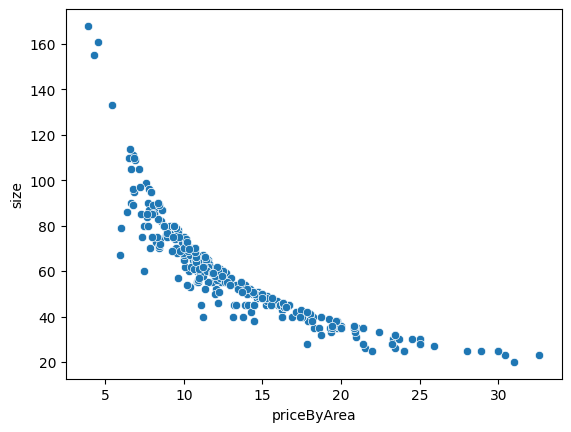

In [46]:
sns.scatterplot(rent_df,
                x="priceByArea",
                y="size")

These two follow a seemingly reciprocal relationship where y=1/x that is almost perfect. Size is a feature that is supposed to be known for every rental unit, where price is the labeled target. If price is the target, we can leverage this relationship by predicting "priceByArea" instead and then calculating the price by multiplying area to the prediction:

$$
\text{priceByArea\_pred} = \hat{y} = \text{model.predict}(X_\text{test})
$$

$$
\text{price\_pred} = \hat{y} \times \text{size}
$$

Then, feature engineering comes in to make this relationship easier to capture as linear by calculating the reciprocal of size:

<Axes: xlabel='priceByArea', ylabel='reciprocal_size'>

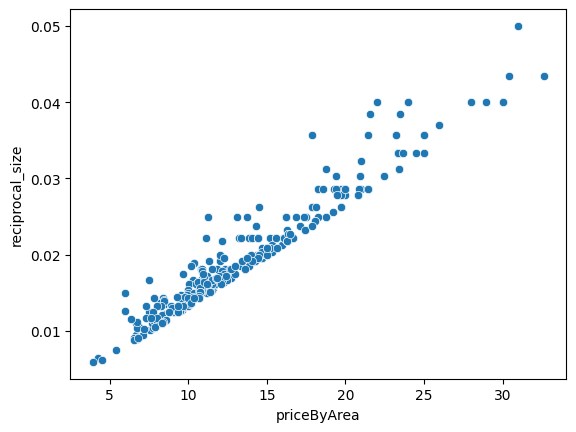

In [47]:
rent_df['reciprocal_size'] = 1 / rent_df['size']

sns.scatterplot(rent_df,
                x="priceByArea",
                y="reciprocal_size")

<Axes: xlabel='priceByArea', ylabel='reciprocal_distance'>

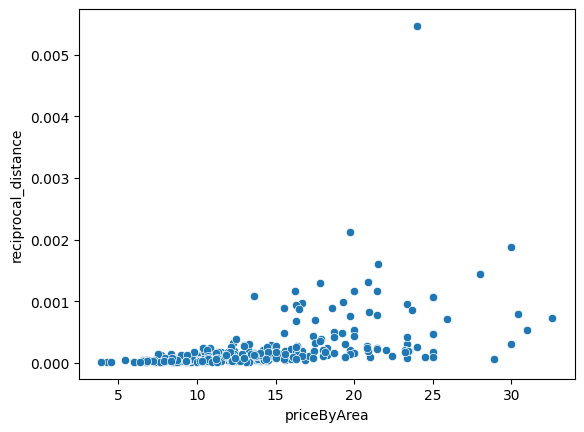

In [48]:
rent_df['reciprocal_distance'] = 1 / rent_df['distance']

sns.scatterplot(rent_df,
                x="priceByArea",
                y="reciprocal_distance")

Now, we can go to the modelling notebook. The same ``rent_df_cleaned.csv`` dataset file will be used, as this notebook is just for preprocessing exploration purposes. All preprocessing operations will be performed in a pipelined manner through scikit-learn methods.